# Figure 5. Sensitivity analyses

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn
import pymare
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats
from modeling.check_fit import load_cmaes

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Load data, calculate age effects and ICCs

This section loads and calculates most of the data and statistics presented in this figure and its supplements.

Load data of the first main run:

In [3]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")
# select first rather than best runs for comparability with the other
# robustness analyses which also were done on one run
first_runs = subjects_optima.loc[subjects_optima['SeedMW']==1].index
data = subjects_optima.loc[first_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

# load I_E
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        I_E.loc[sub, parc] = regional_vars[sub][row['SeedMW']].loc[i, 'I_E']

Randomly select a subset of 200 subjects for the robustness analyses:

In [4]:
data["age_bin"] = pd.cut(data["Age (y)"], 10)
subsample = sklearn.utils.resample(
    data,
    replace=False,
    n_samples=200,
    random_state=0,
    stratify=data[["sex", "age_bin"]],
).index
# filter data to the subsample
data = data.loc[subsample]
I_E = I_E.loc[subsample]

data.to_csv("pnc200_main_data.csv")
I_E.to_csv("pnc200_main_IE.csv")
# write it to a text file to use for running other robustness analysis simulations
np.savetxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), subsample.to_numpy(), fmt="%s")

Split data into two age groups for comparing ICCs between them:

In [5]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

Load alternative simulations data that is used in this figure and its supplements:

In [6]:
all_data = {}
all_I_E = {}
all_data['main'] = data
all_I_E['main'] = I_E

# shared variables used in all runs
itMax = 81
lmbda = 210
n_vols_remove = 10
params = {
    'G': '0.5-4',
    'wee': '0.05-0.75',
    'wei': '0.05-0.75',
    'wie': '0',
}
het_params = 'wee-wei'

for alt in ['sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', '6maps_rot', 'homo', 'node']:
    print(alt)
    # set parcellation
    if alt == 'sch200':
        parcellation_name = 'schaefer-200'
        nodes = 200
    else:
        parcellation_name = 'schaefer-100'
        nodes = 100
    if alt == 'altseed':
        SeedSim = 40
    else:
        SeedSim = 410
    parcels = transform.load_ordered_parcel_labels(parcellation_name)
    if alt not in ['sch200', 'node']:
        # performed using bnm_cuda
        # determine path of pre-curated data
        optima_filename = f'pnc200_{alt}_optima.csv'
        vars_filename = f'pnc200_{alt}_vars.pkz'
        # load pre-curated optima and regional variables data
        if os.path.exists(optima_filename) & os.path.exists(vars_filename):
            curr_subjects_optima = pd.read_csv(optima_filename, index_col=0)
            with open(vars_filename, 'rb') as f:
                curr_regional_vars = pickle.load(f)
        # otherwise curate it
        else:
            # set variables that vary across alternatives
            if alt in ['2maps', 'nmda_gabaa', '4maps', '6maps_rot', 'homo']:
                maps_name = alt
            else:
                maps_name = '6maps'
            if alt == 'homo':
                het_params = 'none'
                cmaes_subdir = os.path.join('homo', 'cmaes_gpu')
            else:
                het_params = 'wee-wei'
                cmaes_subdir = os.path.join(
                    f'{maps_name}_{parcellation_name}_zscore', 
                    'cmaes_multimaps_gpu'
                )
            if alt == 'sc_temp':
                cmaes_analysis_dirname = f'ctx_parc-{parcellation_name}_mean001'
            else: 
                cmaes_analysis_dirname = f'ctx_parc-{parcellation_name}_mean001_thresh-1' 
            if alt == 'inter':
                fc_prefix = f'ctx_parc-{parcellation_name}_hemi-LR_highpass-013_lowpass-none'
                exc_interhemispheric = False
            else:
                fc_prefix = f'ctx_parc-{parcellation_name}_hemi-LR_highpass-013_lowpass-none_exc-inter'
                exc_interhemispheric = True
            SIM_DIR = os.path.join(OUTPUT_DIR["pnc"], 'sim')
            # loop through subjects and load their optimal simulation data
            curr_subjects_optima = []
            curr_regional_vars = {} 
            for sub in tqdm(data.index):
                if alt == 'sc_temp':
                    cmaes_dir = os.path.join(SIM_DIR, 'group-micamics', cmaes_analysis_dirname, sub, cmaes_subdir)
                    sc_path = os.path.join(
                        OUTPUT_DIR["micamics"], 'SC', 'group-all',
                        f'ctx_parc-{parcellation_name}_approach-median_mean001_desc-strength.txt'
                    )
                else:
                    cmaes_dir = os.path.join(SIM_DIR, sub, cmaes_analysis_dirname, cmaes_subdir)
                    sc_path = os.path.join(
                        OUTPUT_DIR["pnc"], 'SC', sub,
                        f'ctx_parc-{parcellation_name}_mean001_thresh-1_desc-strength.txt'
                    )
                sims_dir = cmaes_dir.replace("cmaes_", "sims_")
                emp_fc_tril_path = os.path.join(OUTPUT_DIR["pnc"], 'FC', sub, f'{fc_prefix}_desc-FCtril.txt')
                emp_fcd_tril_path = emp_fc_tril_path.replace('FCtril', 'FCDtril')
                emp_fc_tril = np.loadtxt(emp_fc_tril_path)
                emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
                curr_regional_vars[sub] = {}
                for SeedMW in [1]:
                    cmaes_res = load_cmaes(cmaes_dir, sims_dir, params, het_params,
                                           emp_fc_tril, emp_fcd_tril,
                                           sc_path=sc_path,
                                           n_vols_remove=n_vols_remove,
                                           itMax=itMax, lmbda=lmbda, SeedMW=SeedMW, 
                                           dataset='pnc',
                                           exc_interhemispheric=exc_interhemispheric,
                                           fc_prefix=fc_prefix, SeedSim=SeedSim,
                                          )
                    if cmaes_res:
                        cmaes_res[0]['sub'] = sub
                        cmaes_res[0]['SeedMW'] = SeedMW
                        curr_subjects_optima.append(cmaes_res[0])
                        curr_regional_vars[sub][SeedMW] = cmaes_res[1]
            curr_subjects_optima = pd.DataFrame(curr_subjects_optima)
            curr_subjects_optima.to_csv(optima_filename)
            with open(vars_filename, 'wb') as f:
                pickle.dump(curr_regional_vars, f)
        # select the first run and create I_E dataframe
        if alt == 'main':
            # select the first run (rather than best run) 
            # data to be comparable to other alternatives
            first_runs = curr_subjects_optima.loc[curr_subjects_optima['SeedMW']==1].index
            curr_data = curr_subjects_optima.loc[first_runs].set_index("sub")
        else:
            curr_data = curr_subjects_optima.set_index('sub')
        curr_I_E = pd.DataFrame(index=curr_data.index, columns=parcels, dtype=float)
        for i, parc in enumerate(parcels):
            for sub, row in curr_data.iterrows():
                curr_I_E.loc[sub, parc] = curr_regional_vars[sub][row['SeedMW']].loc[i, 'I_E']
        curr_I_E.to_csv(f'pnc200_{alt}_IE.csv')
    else:
        # performed using cuBNM
        optima_filename = f'pnc200_{alt}_optima.csv'
        I_E_filename = f'pnc200_{alt}_IE.csv'
        # performed using cubnm
        if os.path.exists(optima_filename) & os.path.exists(I_E_filename):
            curr_data = pd.read_csv(optima_filename, index_col=0)
            curr_I_E = pd.read_csv(I_E_filename, index_col=0)
        else:
            if alt == 'node':
                maps_name = 'node'
            else:
                maps_name = '6maps'
            curr_subjects_optima = {}
            curr_I_E = {}
            for sub in tqdm(data.index):
                try:
                    curr_subjects_optima[sub] = pd.read_csv(
                        os.path.join(
                            OUTPUT_DIR['pnc'], 'sim',
                            sub, f'ctx_parc-{parcellation_name}_mean001', 
                            maps_name, 'cmaes_run-0', 'opt.csv'
                        ), index_col=0, header=None).iloc[:, 0]
                except FileNotFoundError:
                    print(sub, "does not exist")
                    continue
                # calculate SC-FC coupling (excluding interhemispheric)
                sc_path = os.path.join(
                    OUTPUT_DIR["pnc"], 'SC', sub,
                    f'ctx_parc-{parcellation_name}_mean001_thresh-1_desc-strength.txt'
                )
                sc = np.loadtxt(sc_path)
                sc[:nodes//2, nodes//2:] = np.NaN
                sc[nodes//2:, :nodes//2] = np.NaN
                sc_tril = sc[np.tril_indices(nodes, -1)]
                sc_tril = sc_tril[~np.isnan(sc_tril)]
                emp_fc_tril_path = os.path.join(
                    OUTPUT_DIR["pnc"], 'FC', sub,
                    f'ctx_parc-{parcellation_name}_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt'
                )
                emp_fc_tril = np.loadtxt(emp_fc_tril_path)
                curr_subjects_optima[sub]['sc_fc'] = np.corrcoef(sc_tril, emp_fc_tril)[0, 1]
                # load simulation data (I_E)
                npz_path = glob(
                    os.path.join(
                        OUTPUT_DIR['pnc'], 'sim',
                        sub, f'ctx_parc-{parcellation_name}_mean001', 
                        maps_name, 'cmaes_run-0', 'opt_sim', 'it*.npz')
                )[0]
                sim_data = np.load(npz_path, allow_pickle=True)
                curr_I_E[sub] = sim_data['sim_states'].reshape(-1)[0]['I_E'].squeeze()
            # collect and save optima
            curr_subjects_optima = pd.DataFrame(curr_subjects_optima).T.drop(columns=[np.NaN])
            # remove + and - from GOF measures
            curr_subjects_optima.columns = [s.replace('-','').replace('+','') for s in curr_subjects_optima.columns]
            curr_subjects_optima['fcd_ks'] = -curr_subjects_optima['fcd_ks']
            curr_subjects_optima['fc_diff'] = -curr_subjects_optima['fc_diff']
            curr_I_E = pd.DataFrame(curr_I_E).T
            curr_I_E.columns = parcels
            curr_subjects_optima.to_csv(optima_filename)
            curr_I_E.to_csv(I_E_filename)
            curr_data = curr_subjects_optima
    # add demographics
    curr_data[['age', 'sex']] = elig_subs.loc[curr_data.index,['age', 'sex']]
    curr_data['Age (y)'] = curr_data['age'] / 12
    # add motion data
    motion = pd.read_csv(
        os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
        delimiter="\t", index_col=0
    ).loc[curr_data.index]
    curr_data = pd.concat([curr_data, motion], axis=1)
    curr_data.to_csv(f'pnc200_{alt}_data.csv')
    all_data[alt] = curr_data
    all_I_E[alt] = curr_I_E

sc_temp
sch200
2maps
nmda_gabaa
4maps
inter
altseed
6maps_rot
homo
node


Calculate the age effects of E-I ratio as well as its ICC (compared to main run) in each configuration across the 200 subsample subjects:

In [7]:
# combination of 'main' and 'altseed' as their average used in Fig. S17D
all_I_E['main_altseed'] = (all_I_E['altseed'] + all_I_E['main']) / 2
all_data['main_altseed'] = all_data['main'].copy()
all_data['main_altseed']['gof'] = (all_data['altseed']['gof'] + all_data['main']['gof']) / 2

In [8]:
all_stats = {}
all_ICCs = {}
all_ICCs_by_age = {}
alts = ['main', 'sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', 'main_altseed', '6maps_rot', 'homo', 'node']
main_alts = ['main', 'sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', 'main_altseed']

for alt in alts:
    print(alt)
    # set parcellation
    if alt == 'sch200':
        parcellation_name = 'schaefer-200'
        nodes = 200
    else:
        parcellation_name = 'schaefer-100'
        nodes = 100
    parcels = transform.load_ordered_parcel_labels(parcellation_name)
    # combine I_E and data
    df = pd.concat([all_I_E[alt], all_data[alt]], axis=1)
    df.columns = [f'IE_{i}' for i in range(nodes)] + list(df.columns[nodes:])
    # calculate parcel-wise age effects
    t = pd.Series(index=parcels)
    r = pd.Series(index=parcels)
    p = pd.Series(index=parcels)
    Ns = pd.Series(index=parcels)
    outliers = {}
    for i, parc in enumerate(parcels):
        # exclude outliers
        curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'IE_{i}']).abs() < 3)]
        outliers[parc] = set(df.index) - set(curr_subs)
        model_df = df.loc[curr_subs]
        # fit the confound removal model to calculate pearson's r of the
        # residual of I_E with age as an easy-to-interpret effect size
        res_conf = smf.ols(f"IE_{i} ~ gof + sex + mean_rms", data=model_df).fit()
        r.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
        # fit the model
        mod = smf.ols(f'IE_{i} ~ age + gof + sex + mean_rms', data=model_df)
        res = mod.fit()
        t.loc[parc] = res.tvalues['age']
        p.loc[parc] = res.pvalues['age']
        Ns.loc[parc] = len(curr_subs)
    
    # FDR correction
    _, p_fdr = statsmodels.stats.multitest.fdrcorrection(p)
    p_fdr = pd.Series(p_fdr, index=parcels)
    
    # aggregate stats
    all_stats[alt] = pd.DataFrame({"t": t, "r": r, "p": p, "p_fdr": p_fdr, "N": Ns})
    all_stats[alt].to_csv(f"p_pnc200_{alt}_IE_age_stats.csv")

    # calculate ICC
    if alt in main_alts[1:]:
        # for schaefer-200 to make the parcels comparable
        # reparcellate main from schaefer-100 to schaefer-200
        if alt == 'sch200':
            I_E_main = transform.parcellate_surf(transform.deparcellate_surf(all_I_E['main'].T, 'schaefer-100'), 'schaefer-200', concat=True).T
            I_E_main.index=all_I_E['main'].index
        else:
            I_E_main = all_I_E['main']
        # ICC across all subjects
        all_ICCs[alt] = pd.Series(index=parcels, dtype=float)
        for i, parc in enumerate(parcels):
            icc_df = pd.DataFrame(index=all_data[alt].index, columns=['main', 'alt'], dtype=float)
            for sub in I_E.index:
                icc_df.loc[sub, 'main'] = I_E_main.loc[sub, parc]
                icc_df.loc[sub, 'alt'] = all_I_E[alt].loc[sub, parc]
            all_ICCs[alt].loc[parc] = stats.madicc(icc_df.loc[:, 'main'], icc_df.loc[:, 'alt'])
        # ICC in younger vs older age groups
        all_ICCs_by_age[alt] = pd.DataFrame(index=parcels, dtype=float)
        for age in data_by_age.keys():
            for i, parc in enumerate(parcels):
                icc_df = pd.DataFrame(index=data_by_age[age].index, columns=['main', 'alt'], dtype=float)
                for sub in data_by_age[age].index:
                    icc_df.loc[sub, 'main'] = I_E_main.loc[sub, parc]
                    icc_df.loc[sub, 'alt'] = all_I_E[alt].loc[sub, parc]
                all_ICCs_by_age[alt].loc[parc, age] = stats.madicc(icc_df.loc[:, 'main'], icc_df.loc[:, 'alt'])
        all_ICCs_by_age[alt]['all'] = all_ICCs[alt]
        # save
        all_ICCs_by_age[alt].to_csv(f'p_pnc200_{alt}_IE_icc.csv')

main
sc_temp
sch200
2maps
nmda_gabaa
4maps
inter
altseed
main_altseed
6maps_rot
homo
node


## A. Main run with default configurations 

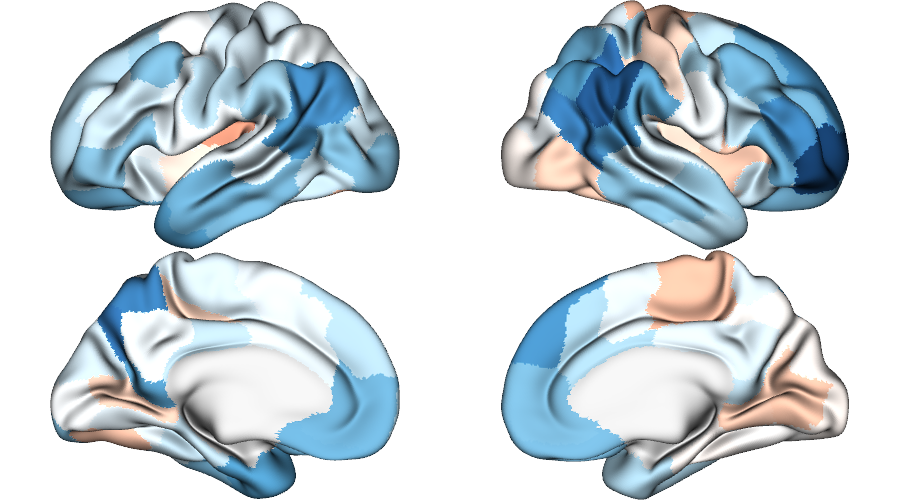

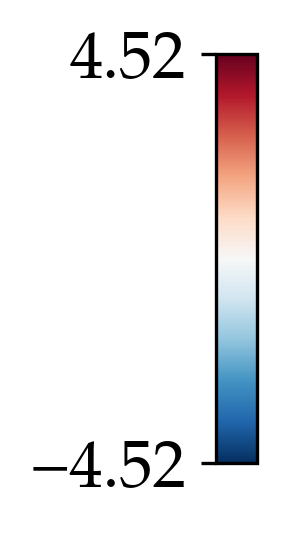

In [9]:
vmin = min(all_stats['main']['t'].values.min(), -all_stats['main']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['main']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5A.svg'
)

## B. Effect of age on E-I ratio using template SC (unthresholded)

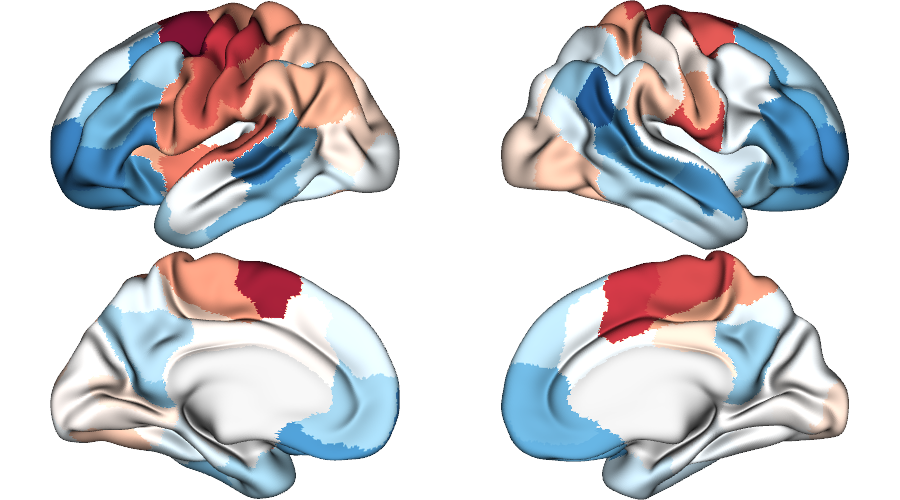

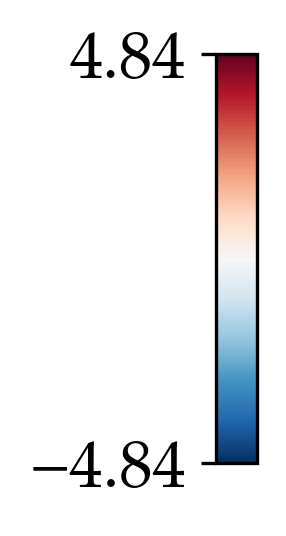

In [10]:
vmin = min(all_stats['sc_temp']['t'].values.min(), -all_stats['sc_temp']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['sc_temp']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5B.svg'
)

## C. Effect of age on E-I ratio using Schaefer-200 parcellation (unthresholded)

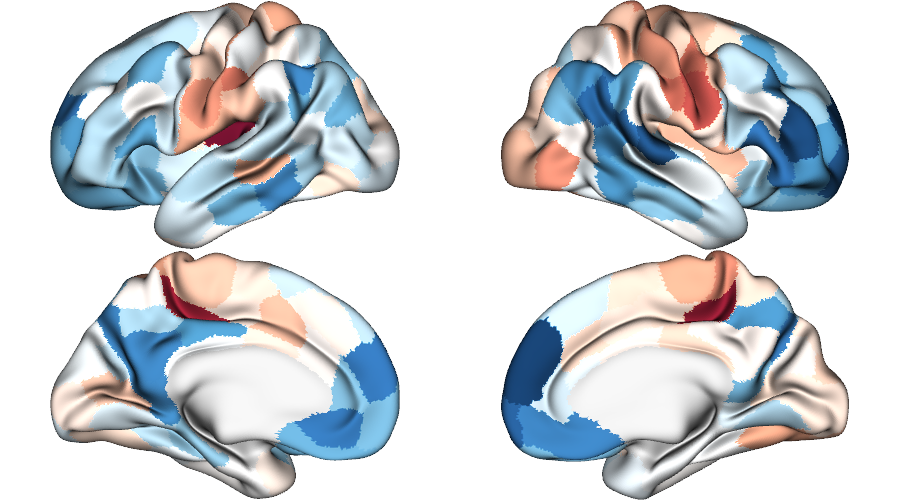

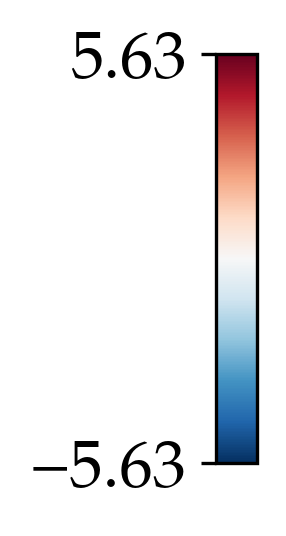

In [11]:
vmin = min(all_stats['sch200']['t'].values.min(), -all_stats['sch200']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['sch200']['t'], 'schaefer-200', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5C.svg'
)

## D. Effect of age on E-I ratio using alternative sets of maps (unthresholded)

Note: Alternative sets of maps were created using the following code:

```python
maps = datasets.load_maps('schaefer-100', '6maps')
np.savetxt(
    os.path.join(INPUT_DIR, '2maps_schaefer-100_zscore.txt'), 
    maps.loc[:, ['myelinmap', 'fcgradient01']].values.T, fmt="%f"
)
np.savetxt(
    os.path.join(INPUT_DIR, 'nmda_gabaa_schaefer-100_zscore.txt'), 
    maps.loc[:, ['nmda', 'gabaa']].values.T, fmt="%f"
)
np.savetxt(
    os.path.join(INPUT_DIR, 'nmda_gabaa_schaefer-100_zscore.txt'), 
    maps.loc[:, ['myelinmap', 'fcgradient01', 'nmda', 'gabaa']].values.T, fmt="%f"
)
```

### (left) T1w/T2w & FC G1

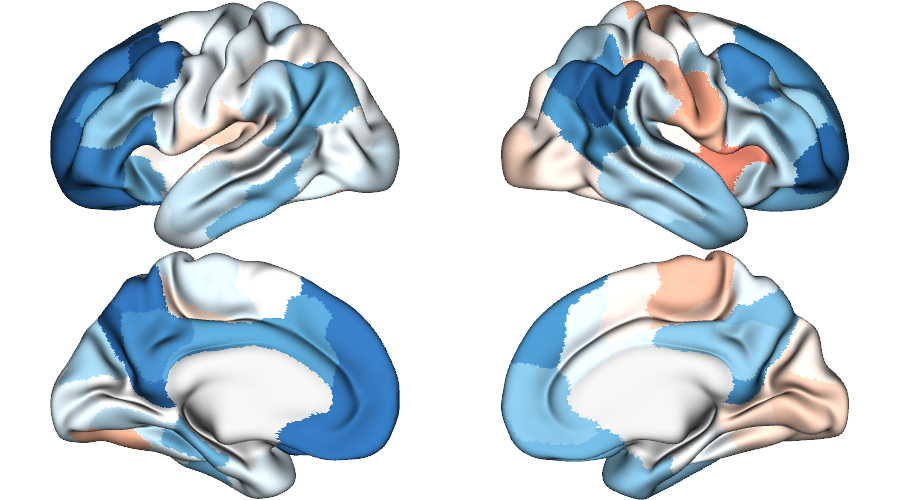

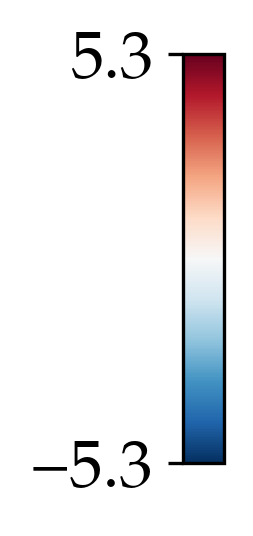

In [12]:
vmin = min(all_stats['2maps']['t'].values.min(), -all_stats['2maps']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['2maps']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5D0.svg'
)

### (middle) NMDA & GABA$_{A/BZ}$

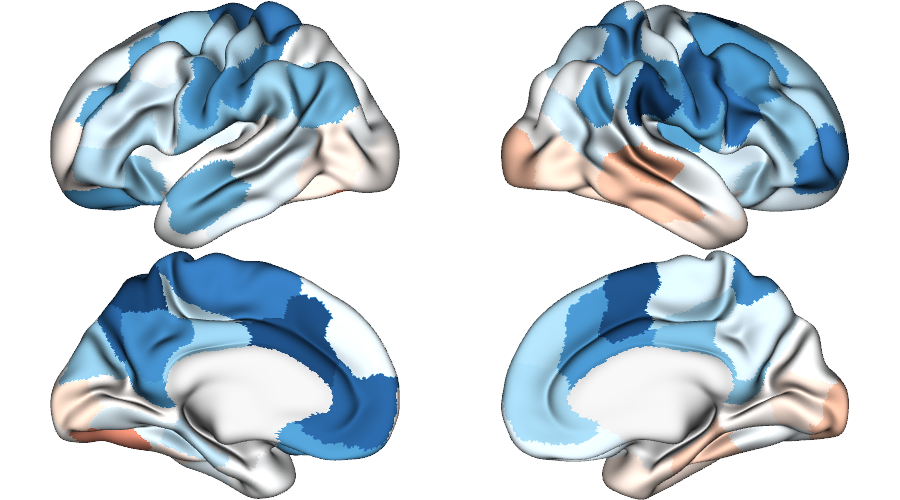

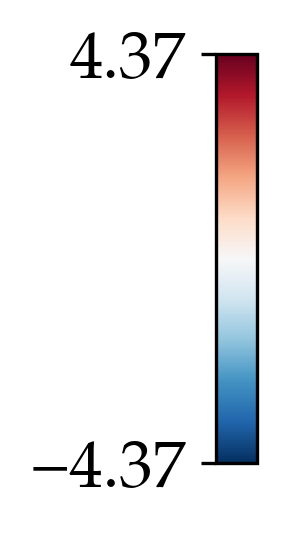

In [13]:
vmin = min(all_stats['nmda_gabaa']['t'].values.min(), -all_stats['nmda_gabaa']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['nmda_gabaa']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5D1.svg'
)

### (right) T1w/T2w, FC G1, NMDA & GABA$_{A/BZ}$

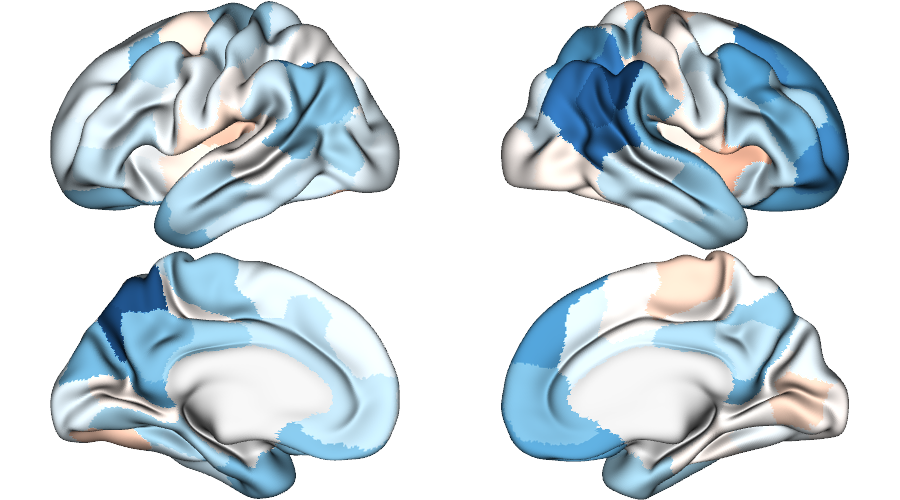

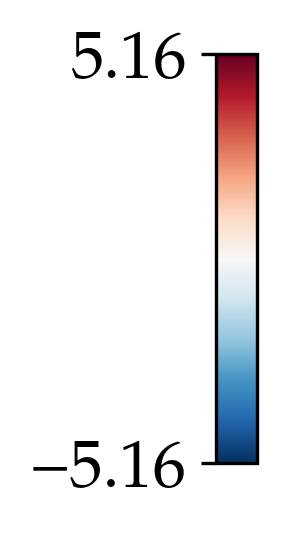

In [14]:
vmin = min(all_stats['4maps']['t'].values.min(), -all_stats['4maps']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['4maps']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5D2.svg'
)

## E. Effect of age on E-I ratio with inter-hemispheric connections in cost (unthresholded)

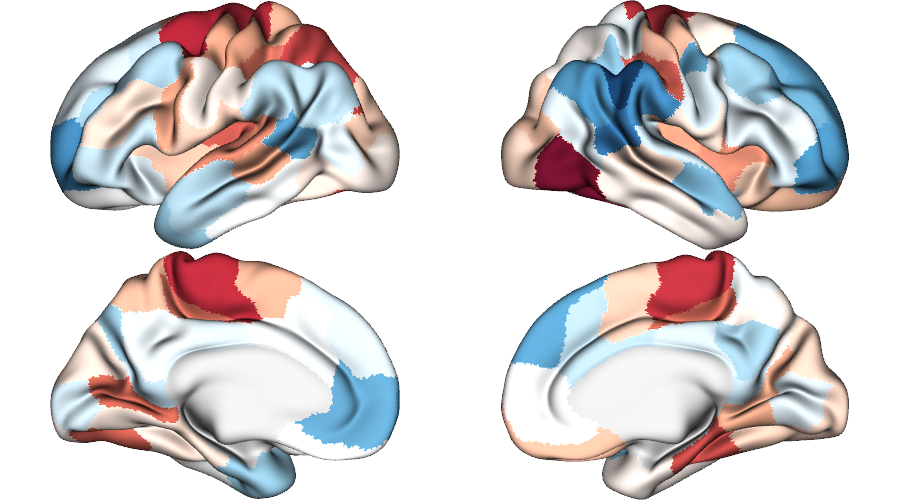

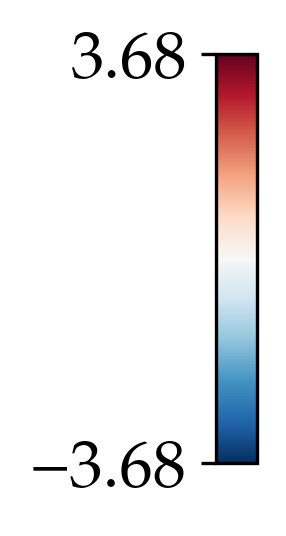

In [15]:
vmin = min(all_stats['inter']['t'].values.min(), -all_stats['inter']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['inter']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5E.svg'
)

## F. Effect of age on E-I ratio using alternative noise seed

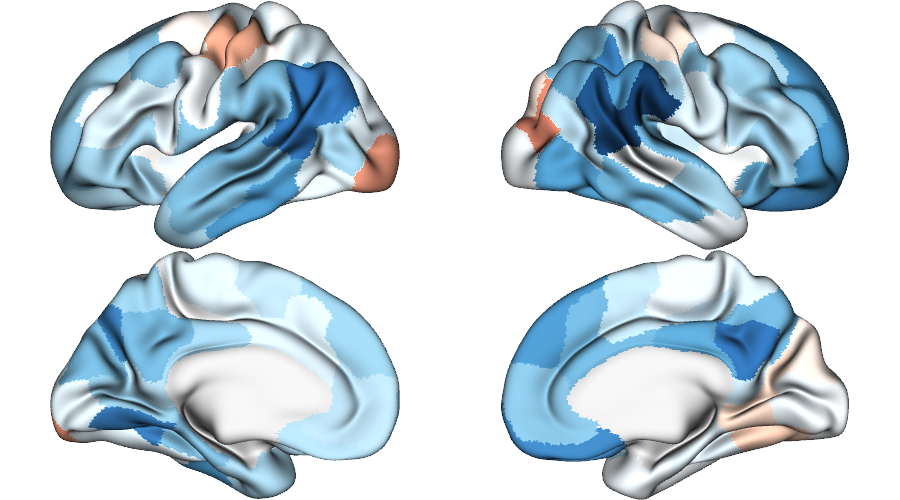

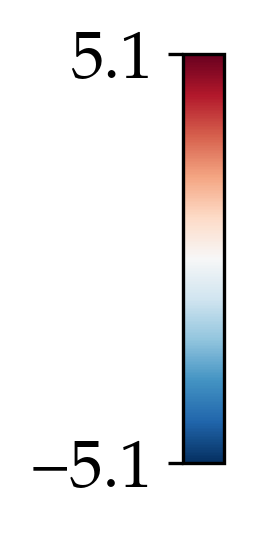

In [16]:
vmin = min(all_stats['altseed']['t'].values.min(), -all_stats['altseed']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['altseed']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5F.svg'
)

## G. Pooled age effects

In [17]:
# for schaefer-200 reparcellate it into schaefer-100 so the maps can be combined
all_stats['sch200reparc'] = transform.parcellate_surf(transform.deparcellate_surf(all_stats['sch200'], 'schaefer-200'), 'schaefer-100', concat=True)
all_stats['sch200reparc'].columns = all_stats['main'].columns
all_stats['sch200reparc']['N'] = all_stats['sch200reparc']['N'].round().astype('int')

# convert Rs and Ns of analyses reported in Fig 5 to dataframes
# which will be used in the meta-analyses
meta_alts = ['main', 'sc_temp', 'sch200reparc', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed']
all_Rs = pd.DataFrame({k: all_stats[k]['r'] for k in meta_alts})
all_Ns = pd.DataFrame({k: all_stats[k]['N'].astype('int') for k in meta_alts})

# in each node run a REML meta-aanlysis using PyMARE
# with the partial correlation of age with <I_Ei> as the effect size
meta_results = {}
for parc in parcels:
    dset = pymare.effectsize.OneSampleEffectSizeConverter(
        r = all_Rs.loc[parc, :], 
        n = all_Ns.loc[parc, :]
    ).to_dataset(measure='R')
    est = pymare.estimators.VarianceBasedLikelihoodEstimator(method="REML").fit_dataset(dset)
    results = est.summary()
    meta_results[parc] = results.to_df().iloc[0, 1:]
    meta_het_stats = results.get_heterogeneity_stats()
    meta_results[parc]['I^2'] = meta_het_stats['I^2'][0]
    meta_results[parc]['p(Q)'] = meta_het_stats['p(Q)'][0]
meta_results = pd.DataFrame(meta_results).T.astype(float)
# FDR correction
_, meta_results['p_fdr'] = statsmodels.stats.multitest.fdrcorrection(meta_results['p-value'])
meta_results.to_csv('p_pnc200_IE_age_meta.csv')

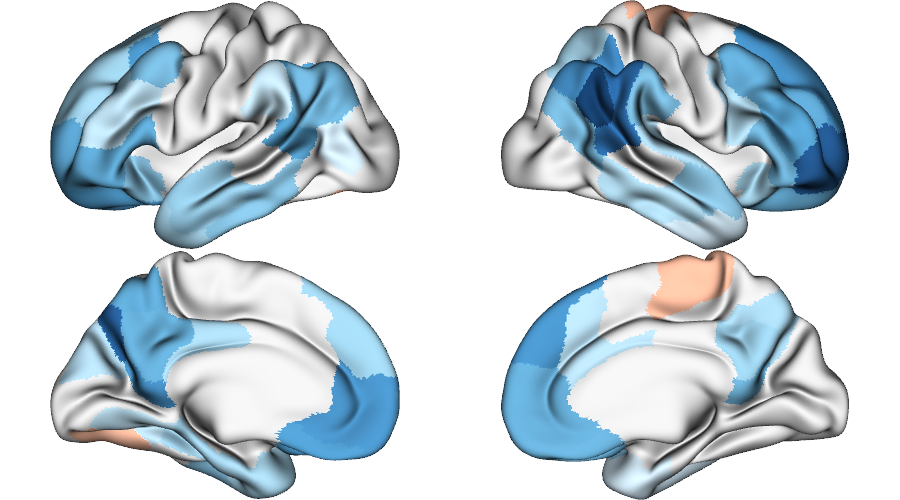

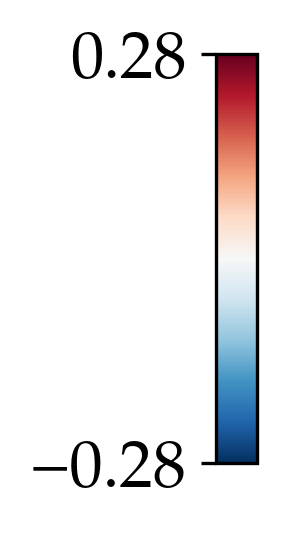

In [18]:
vmin = min(meta_results['estimate'].values.min(), -meta_results['estimate'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        meta_results['estimate'][meta_results['p_fdr']<0.05], 
        'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
    # filename='./figures/5G.svg'
)